## Neural Network Model to Predict Hospital Admission Costs


In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

In [3]:
#import preprocessed data (preprocessing & saving done in the other notebook)
df = pd.read_csv('preprocessed_data/data_preprocessed.csv')
df.head()

,patient_id,date_of_birth,gender,race,resident_status,weight,height,BMI_value,BMI_class,age_on_admission,date_of_admission,date_of_discharge,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq
0,62bdca0b95d97e99e1c712048fb9fd09,1978-07-20,f,Malay,Singaporean,78.4,160.0,30.625000,obese,32,2011-01-01,2011-01-11,10,1,23303.000924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,13.8,22.6,89.0,0
1,1d21f2be18683991eb93d182d6b2d220,1976-12-19,m,Indian,Singaporean,71.3,161.0,27.506655,obese,34,2011-01-01,2011-01-11,10,2,15405.418665,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,13.2,30.9,123.0,0
2,79f52395dab0e6d3a03c48f765cb6562,1936-04-05,m,Chinese,Singaporean,92.8,176.0,29.958678,obese,74,2011-01-02,2011-01-18,16,1,17153.905421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,12.1,23.6,109.0,0
3,e0397dd72caf4552c5babebd3d61736c,1967-12-06,f,Chinese,Singaporean,64.4,152.0,27.873961,obese,43,2011-01-02,2011-01-14,12,1,27994.878530,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.3,28.4,76.0,0
4,c85cf97bc6307ded0dd4fef8bad2fa09,1967-08-14,f,Indian,Singaporean,72.0,151.0,31.577562,obese,43,2011-01-02,2011-01-13,11,2,16813.123088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,11.2,26.2,100.0,0


In [4]:
#choose features 
data = df[['gender', 'race', 'resident_status', 'BMI_value', 'age_on_admission', 'length_of_stay', 'total_admissions', 'amount', 'medical_history_1', 'medical_history_6', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'freq']]

In [5]:
data = pd.get_dummies(data, drop_first = True)
data.head()

,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,freq,gender_m,race_Indian,race_Malay,race_Other,resident_status_Singaporean
0,30.625000,32,10,1,23303.000924,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0,1,0,1
1,27.506655,34,10,2,15405.418665,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,1,0,0,1
2,29.958678,74,16,1,17153.905421,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0,0,1
3,27.873961,43,12,1,27994.878530,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,1
4,31.577562,43,11,2,16813.123088,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0,0,1,0,0,1


### Train, test and validation data

In [6]:
#train data (90% of the data) and test data (10% of the data)
x = data.drop('amount', axis = 1)
y = data['amount']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 25, shuffle = True)

#let's further separate validation data set (10 % from the train data): 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 25, shuffle = True)

#scale
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

print(f"training examples: {x_train.shape[0]}")
print(f"testing examples: {x_test.shape[0]}")
print(f'validation examples: {x_val.shape[0]}')

training examples: 2347
testing examples: 290
validation examples: 261


In [7]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(2347, 17) (261, 17) (290, 17) (2347,) (261,) (290,)


### Neural Network Model

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

model=keras.models.Sequential([
    keras.layers.Dense(200, input_dim = x_train.shape[1], activation='relu'),  
    keras.layers.Dense(100, input_dim = x_train.shape[1], activation='relu'),  
    keras.layers.Dense(1, activation='linear'),  
])
    
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), tf.keras.metrics.MeanAbsoluteError(name='mae')]) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               3600      
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23,801
Trainable params: 23,801
Non-trainable params: 0
_________________________________________________________________


2022-01-27 16:20:05.256360: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
history = model.fit(x_train, y_train,
                    epochs=1000, batch_size=500,
                    validation_data=(x_test, y_test), 
                    verbose=1, shuffle = True, validation_split = 0.2)

Epoch 1/1000
4/4 [==============================] - 1s 112ms/step - loss: 588882176.0000 - rmse: 24266.8945 - mae: 21875.9941 - val_loss: 584714304.0000 - val_rmse: 24180.8672 - val_mae: 22010.3906
Epoch 2/1000
4/4 [==============================] - 0s 19ms/step - loss: 588837248.0000 - rmse: 24265.9688 - mae: 21875.0312 - val_loss: 584668416.0000 - val_rmse: 24179.9180 - val_mae: 22009.3984
Epoch 3/1000
4/4 [==============================] - 0s 16ms/step - loss: 588789696.0000 - rmse: 24264.9883 - mae: 21874.0098 - val_loss: 584617920.0000 - val_rmse: 24178.8730 - val_mae: 22008.3027
Epoch 4/1000
4/4 [==============================] - 0s 16ms/step - loss: 588737152.0000 - rmse: 24263.9062 - mae: 21872.8828 - val_loss: 584560064.0000 - val_rmse: 24177.6777 - val_mae: 22007.0625
Epoch 5/1000
4/4 [==============================] - 0s 18ms/step - loss: 588675648.0000 - rmse: 24262.6387 - mae: 21871.5781 - val_loss: 584492480.0000 - val_rmse: 24176.2793 - val_mae: 22005.6191
Epoch 6/1000
4

4/4 [==============================] - 0s 23ms/step - loss: 553464512.0000 - rmse: 23525.8262 - mae: 21200.4961 - val_loss: 547835328.0000 - val_rmse: 23405.8828 - val_mae: 21297.4961
Epoch 43/1000
4/4 [==============================] - 0s 20ms/step - loss: 550730560.0000 - rmse: 23467.6484 - mae: 21148.2539 - val_loss: 545002880.0000 - val_rmse: 23345.2969 - val_mae: 21243.0605
Epoch 44/1000
4/4 [==============================] - 0s 16ms/step - loss: 547792768.0000 - rmse: 23404.9727 - mae: 21093.0527 - val_loss: 542043072.0000 - val_rmse: 23281.8184 - val_mae: 21185.9902
Epoch 45/1000
4/4 [==============================] - 0s 16ms/step - loss: 544787584.0000 - rmse: 23340.6855 - mae: 21035.5527 - val_loss: 538923200.0000 - val_rmse: 23214.7188 - val_mae: 21125.8027
Epoch 46/1000
4/4 [==============================] - 0s 23ms/step - loss: 541611584.0000 - rmse: 23272.5508 - mae: 20974.9961 - val_loss: 535651648.0000 - val_rmse: 23144.1484 - val_mae: 21062.5645
Epoch 47/1000
4/4 [=====

4/4 [==============================] - 0s 18ms/step - loss: 319658528.0000 - rmse: 17878.9961 - mae: 16255.2764 - val_loss: 312805952.0000 - val_rmse: 17686.3203 - val_mae: 16222.7275
Epoch 84/1000
4/4 [==============================] - 0s 18ms/step - loss: 311558912.0000 - rmse: 17651.0312 - mae: 16056.6660 - val_loss: 304827808.0000 - val_rmse: 17459.3184 - val_mae: 16020.8701
Epoch 85/1000
4/4 [==============================] - 0s 22ms/step - loss: 303565024.0000 - rmse: 17423.1172 - mae: 15854.9873 - val_loss: 296823104.0000 - val_rmse: 17228.5547 - val_mae: 15815.4736
Epoch 86/1000
4/4 [==============================] - 0s 23ms/step - loss: 295460864.0000 - rmse: 17188.9746 - mae: 15649.8623 - val_loss: 288813376.0000 - val_rmse: 16994.5098 - val_mae: 15607.0029
Epoch 87/1000
4/4 [==============================] - 0s 17ms/step - loss: 287398816.0000 - rmse: 16952.8418 - mae: 15442.9258 - val_loss: 280806976.0000 - val_rmse: 16757.2969 - val_mae: 15395.3779
Epoch 88/1000
4/4 [=====

Epoch 125/1000
4/4 [==============================] - 0s 18ms/step - loss: 56453796.0000 - rmse: 7513.5742 - mae: 6646.4785 - val_loss: 53616668.0000 - val_rmse: 7322.3403 - val_mae: 6533.5649
Epoch 126/1000
4/4 [==============================] - 0s 16ms/step - loss: 53571316.0000 - rmse: 7319.2427 - mae: 6449.5254 - val_loss: 50820620.0000 - val_rmse: 7128.8584 - val_mae: 6337.4014
Epoch 127/1000
4/4 [==============================] - 0s 16ms/step - loss: 50857860.0000 - rmse: 7131.4697 - mae: 6257.4351 - val_loss: 48177584.0000 - val_rmse: 6941.0073 - val_mae: 6145.4014
Epoch 128/1000
4/4 [==============================] - 0s 15ms/step - loss: 48288692.0000 - rmse: 6949.0063 - mae: 6070.7725 - val_loss: 45683276.0000 - val_rmse: 6758.9404 - val_mae: 5958.7749
Epoch 129/1000
4/4 [==============================] - 0s 15ms/step - loss: 45858292.0000 - rmse: 6771.8750 - mae: 5891.3296 - val_loss: 43343268.0000 - val_rmse: 6583.5605 - val_mae: 5776.9609
Epoch 130/1000
4/4 [===============

4/4 [==============================] - 0s 17ms/step - loss: 13653493.0000 - rmse: 3695.0632 - mae: 2922.5251 - val_loss: 12477343.0000 - val_rmse: 3532.3284 - val_mae: 2905.4038
Epoch 168/1000
4/4 [==============================] - 0s 16ms/step - loss: 13457362.0000 - rmse: 3668.4277 - mae: 2896.9639 - val_loss: 12303357.0000 - val_rmse: 3507.6143 - val_mae: 2884.8369
Epoch 169/1000
4/4 [==============================] - 0s 16ms/step - loss: 13277327.0000 - rmse: 3643.8066 - mae: 2873.6904 - val_loss: 12134716.0000 - val_rmse: 3483.4919 - val_mae: 2863.8862
Epoch 170/1000
4/4 [==============================] - 0s 22ms/step - loss: 13102329.0000 - rmse: 3619.7139 - mae: 2850.0945 - val_loss: 11976511.0000 - val_rmse: 3460.7097 - val_mae: 2843.6660
Epoch 171/1000
4/4 [==============================] - 0s 15ms/step - loss: 12942529.0000 - rmse: 3597.5728 - mae: 2828.6204 - val_loss: 11825668.0000 - val_rmse: 3438.8469 - val_mae: 2824.0103
Epoch 172/1000
4/4 [==============================

Epoch 210/1000
4/4 [==============================] - 0s 17ms/step - loss: 9938915.0000 - rmse: 3152.6045 - mae: 2384.7285 - val_loss: 9105080.0000 - val_rmse: 3017.4624 - val_mae: 2403.5750
Epoch 211/1000
4/4 [==============================] - 0s 15ms/step - loss: 9906336.0000 - rmse: 3147.4333 - mae: 2378.9009 - val_loss: 9075093.0000 - val_rmse: 3012.4895 - val_mae: 2397.9187
Epoch 212/1000
4/4 [==============================] - 0s 15ms/step - loss: 9873482.0000 - rmse: 3142.2097 - mae: 2372.9207 - val_loss: 9046051.0000 - val_rmse: 3007.6653 - val_mae: 2392.4553
Epoch 213/1000
4/4 [==============================] - 0s 17ms/step - loss: 9842046.0000 - rmse: 3137.2036 - mae: 2367.1721 - val_loss: 9018955.0000 - val_rmse: 3003.1575 - val_mae: 2387.2581
Epoch 214/1000
4/4 [==============================] - 0s 16ms/step - loss: 9811745.0000 - rmse: 3132.3706 - mae: 2361.9648 - val_loss: 8992550.0000 - val_rmse: 2998.7581 - val_mae: 2382.0586
Epoch 215/1000
4/4 [=========================

Epoch 253/1000
4/4 [==============================] - 0s 15ms/step - loss: 9030462.0000 - rmse: 3005.0728 - mae: 2215.7805 - val_loss: 8336901.5000 - val_rmse: 2887.3694 - val_mae: 2245.2595
Epoch 254/1000
4/4 [==============================] - 0s 15ms/step - loss: 9016018.0000 - rmse: 3002.6685 - mae: 2213.1028 - val_loss: 8325293.0000 - val_rmse: 2885.3584 - val_mae: 2242.7168
Epoch 255/1000
4/4 [==============================] - 0s 15ms/step - loss: 9001245.0000 - rmse: 3000.2075 - mae: 2210.2954 - val_loss: 8312757.5000 - val_rmse: 2883.1853 - val_mae: 2240.2610
Epoch 256/1000
4/4 [==============================] - 0s 15ms/step - loss: 8987040.0000 - rmse: 2997.8391 - mae: 2207.4915 - val_loss: 8299201.5000 - val_rmse: 2880.8335 - val_mae: 2237.6624
Epoch 257/1000
4/4 [==============================] - 0s 16ms/step - loss: 8972239.0000 - rmse: 2995.3696 - mae: 2204.7202 - val_loss: 8286112.0000 - val_rmse: 2878.5608 - val_mae: 2235.2832
Epoch 258/1000
4/4 [=========================

Epoch 296/1000
4/4 [==============================] - 0s 16ms/step - loss: 8473540.0000 - rmse: 2910.9343 - mae: 2117.7737 - val_loss: 7894578.5000 - val_rmse: 2809.7292 - val_mae: 2160.9954
Epoch 297/1000
4/4 [==============================] - 0s 16ms/step - loss: 8461519.0000 - rmse: 2908.8691 - mae: 2115.5479 - val_loss: 7884538.5000 - val_rmse: 2807.9421 - val_mae: 2159.1313
Epoch 298/1000
4/4 [==============================] - 0s 16ms/step - loss: 8450139.0000 - rmse: 2906.9124 - mae: 2113.3623 - val_loss: 7874687.0000 - val_rmse: 2806.1873 - val_mae: 2157.2214
Epoch 299/1000
4/4 [==============================] - 0s 16ms/step - loss: 8437555.0000 - rmse: 2904.7471 - mae: 2111.2932 - val_loss: 7865483.5000 - val_rmse: 2804.5469 - val_mae: 2155.6272
Epoch 300/1000
4/4 [==============================] - 0s 15ms/step - loss: 8425656.0000 - rmse: 2902.6980 - mae: 2109.3411 - val_loss: 7856382.5000 - val_rmse: 2802.9238 - val_mae: 2154.1084
Epoch 301/1000
4/4 [=========================

Epoch 339/1000
4/4 [==============================] - 0s 16ms/step - loss: 7984205.0000 - rmse: 2825.6335 - mae: 2038.6068 - val_loss: 7525833.5000 - val_rmse: 2743.3252 - val_mae: 2096.7542
Epoch 340/1000
4/4 [==============================] - 0s 16ms/step - loss: 7973911.5000 - rmse: 2823.8115 - mae: 2037.1766 - val_loss: 7520492.0000 - val_rmse: 2742.3516 - val_mae: 2096.0801
Epoch 341/1000
4/4 [==============================] - 0s 21ms/step - loss: 7962340.0000 - rmse: 2821.7620 - mae: 2035.5980 - val_loss: 7511400.0000 - val_rmse: 2740.6934 - val_mae: 2094.3853
Epoch 342/1000
4/4 [==============================] - 0s 19ms/step - loss: 7951251.0000 - rmse: 2819.7964 - mae: 2033.7740 - val_loss: 7502980.0000 - val_rmse: 2739.1567 - val_mae: 2092.9023
Epoch 343/1000
4/4 [==============================] - 0s 19ms/step - loss: 7940649.5000 - rmse: 2817.9158 - mae: 2032.2864 - val_loss: 7497149.5000 - val_rmse: 2738.0923 - val_mae: 2091.9563
Epoch 344/1000
4/4 [=========================

Epoch 382/1000
4/4 [==============================] - 0s 19ms/step - loss: 7542607.0000 - rmse: 2746.3806 - mae: 1972.0009 - val_loss: 7216485.5000 - val_rmse: 2686.3518 - val_mae: 2045.8276
Epoch 383/1000
4/4 [==============================] - 0s 24ms/step - loss: 7532461.0000 - rmse: 2744.5330 - mae: 1970.2360 - val_loss: 7208787.0000 - val_rmse: 2684.9185 - val_mae: 2044.7712
Epoch 384/1000
4/4 [==============================] - 0s 16ms/step - loss: 7523054.5000 - rmse: 2742.8186 - mae: 1969.0363 - val_loss: 7202712.5000 - val_rmse: 2683.7869 - val_mae: 2044.0154
Epoch 385/1000
4/4 [==============================] - 0s 21ms/step - loss: 7513221.0000 - rmse: 2741.0256 - mae: 1967.6505 - val_loss: 7193233.0000 - val_rmse: 2682.0203 - val_mae: 2042.2798
Epoch 386/1000
4/4 [==============================] - 0s 14ms/step - loss: 7504475.0000 - rmse: 2739.4297 - mae: 1966.4559 - val_loss: 7187034.0000 - val_rmse: 2680.8645 - val_mae: 2041.2526
Epoch 387/1000
4/4 [=========================

Epoch 425/1000
4/4 [==============================] - 0s 19ms/step - loss: 7140171.5000 - rmse: 2672.1099 - mae: 1910.5778 - val_loss: 6932396.0000 - val_rmse: 2632.9443 - val_mae: 1997.8944
Epoch 426/1000
4/4 [==============================] - 0s 27ms/step - loss: 7131018.5000 - rmse: 2670.3967 - mae: 1908.9377 - val_loss: 6927171.5000 - val_rmse: 2631.9521 - val_mae: 1996.9456
Epoch 427/1000
4/4 [==============================] - 0s 16ms/step - loss: 7122197.0000 - rmse: 2668.7444 - mae: 1907.5901 - val_loss: 6919187.0000 - val_rmse: 2630.4348 - val_mae: 1995.5474
Epoch 428/1000
4/4 [==============================] - 0s 18ms/step - loss: 7112937.5000 - rmse: 2667.0090 - mae: 1906.0756 - val_loss: 6913420.5000 - val_rmse: 2629.3384 - val_mae: 1994.5045
Epoch 429/1000
4/4 [==============================] - 0s 24ms/step - loss: 7104586.5000 - rmse: 2665.4431 - mae: 1904.5503 - val_loss: 6905586.5000 - val_rmse: 2627.8481 - val_mae: 1993.0793
Epoch 430/1000
4/4 [=========================

Epoch 468/1000
4/4 [==============================] - 0s 16ms/step - loss: 6777717.5000 - rmse: 2603.4050 - mae: 1852.8781 - val_loss: 6678271.0000 - val_rmse: 2584.2351 - val_mae: 1953.8026
Epoch 469/1000
4/4 [==============================] - 0s 18ms/step - loss: 6769928.5000 - rmse: 2601.9087 - mae: 1851.5712 - val_loss: 6671434.5000 - val_rmse: 2582.9121 - val_mae: 1952.3872
Epoch 470/1000
4/4 [==============================] - 0s 18ms/step - loss: 6762262.0000 - rmse: 2600.4351 - mae: 1850.3834 - val_loss: 6665888.5000 - val_rmse: 2581.8381 - val_mae: 1951.4885
Epoch 471/1000
4/4 [==============================] - 0s 16ms/step - loss: 6753732.5000 - rmse: 2598.7944 - mae: 1849.1328 - val_loss: 6662076.0000 - val_rmse: 2581.0999 - val_mae: 1950.7203
Epoch 472/1000
4/4 [==============================] - 0s 14ms/step - loss: 6746083.0000 - rmse: 2597.3223 - mae: 1847.9778 - val_loss: 6656567.0000 - val_rmse: 2580.0325 - val_mae: 1949.7173
Epoch 473/1000
4/4 [=========================

Epoch 511/1000
4/4 [==============================] - 0s 17ms/step - loss: 6452309.5000 - rmse: 2540.1396 - mae: 1800.2191 - val_loss: 6452972.0000 - val_rmse: 2540.2700 - val_mae: 1911.1306
Epoch 512/1000
4/4 [==============================] - 0s 15ms/step - loss: 6445228.5000 - rmse: 2538.7454 - mae: 1799.0566 - val_loss: 6447080.5000 - val_rmse: 2539.1101 - val_mae: 1910.0481
Epoch 513/1000
4/4 [==============================] - 0s 19ms/step - loss: 6438062.0000 - rmse: 2537.3337 - mae: 1797.6738 - val_loss: 6441512.5000 - val_rmse: 2538.0134 - val_mae: 1908.9072
Epoch 514/1000
4/4 [==============================] - 0s 19ms/step - loss: 6430486.0000 - rmse: 2535.8403 - mae: 1796.4354 - val_loss: 6438139.5000 - val_rmse: 2537.3489 - val_mae: 1908.3274
Epoch 515/1000
4/4 [==============================] - 0s 23ms/step - loss: 6423619.0000 - rmse: 2534.4858 - mae: 1795.5719 - val_loss: 6435144.5000 - val_rmse: 2536.7585 - val_mae: 1907.9036
Epoch 516/1000
4/4 [=========================

Epoch 554/1000
4/4 [==============================] - 0s 19ms/step - loss: 6155337.0000 - rmse: 2480.9951 - mae: 1752.3024 - val_loss: 6255065.0000 - val_rmse: 2501.0127 - val_mae: 1872.9987
Epoch 555/1000
4/4 [==============================] - 0s 24ms/step - loss: 6148773.0000 - rmse: 2479.6719 - mae: 1750.7035 - val_loss: 6248839.5000 - val_rmse: 2499.7678 - val_mae: 1871.7426
Epoch 556/1000
4/4 [==============================] - 0s 34ms/step - loss: 6142202.5000 - rmse: 2478.3467 - mae: 1749.3506 - val_loss: 6243867.0000 - val_rmse: 2498.7732 - val_mae: 1870.8333
Epoch 557/1000
4/4 [==============================] - 0s 25ms/step - loss: 6135789.5000 - rmse: 2477.0525 - mae: 1748.2313 - val_loss: 6240233.5000 - val_rmse: 2498.0459 - val_mae: 1870.1505
Epoch 558/1000
4/4 [==============================] - 0s 26ms/step - loss: 6128952.5000 - rmse: 2475.6721 - mae: 1747.2411 - val_loss: 6235956.5000 - val_rmse: 2497.1897 - val_mae: 1869.5023
Epoch 559/1000
4/4 [=========================

Epoch 597/1000
4/4 [==============================] - 0s 23ms/step - loss: 5886835.0000 - rmse: 2426.2800 - mae: 1708.3131 - val_loss: 6079764.5000 - val_rmse: 2465.7178 - val_mae: 1839.8763
Epoch 598/1000
4/4 [==============================] - 0s 33ms/step - loss: 5880596.0000 - rmse: 2424.9941 - mae: 1707.7585 - val_loss: 6079490.5000 - val_rmse: 2465.6624 - val_mae: 1839.9170
Epoch 599/1000
4/4 [==============================] - 0s 60ms/step - loss: 5874475.0000 - rmse: 2423.7317 - mae: 1706.9834 - val_loss: 6076074.0000 - val_rmse: 2464.9695 - val_mae: 1838.9938
Epoch 600/1000
4/4 [==============================] - 0s 29ms/step - loss: 5868253.0000 - rmse: 2422.4478 - mae: 1705.8572 - val_loss: 6072089.5000 - val_rmse: 2464.1611 - val_mae: 1838.1158
Epoch 601/1000
4/4 [==============================] - 0s 42ms/step - loss: 5863072.0000 - rmse: 2421.3782 - mae: 1704.4663 - val_loss: 6064310.0000 - val_rmse: 2462.5820 - val_mae: 1836.2793
Epoch 602/1000
4/4 [=========================

4/4 [==============================] - 0s 14ms/step - loss: 5648546.5000 - rmse: 2376.6670 - mae: 1669.0862 - val_loss: 5923555.0000 - val_rmse: 2433.8354 - val_mae: 1807.1653
Epoch 640/1000
4/4 [==============================] - 0s 18ms/step - loss: 5642382.0000 - rmse: 2375.3699 - mae: 1667.4241 - val_loss: 5921132.5000 - val_rmse: 2433.3376 - val_mae: 1806.4965
Epoch 641/1000
4/4 [==============================] - 0s 24ms/step - loss: 5637042.0000 - rmse: 2374.2456 - mae: 1666.6617 - val_loss: 5920127.0000 - val_rmse: 2433.1311 - val_mae: 1806.4877
Epoch 642/1000
4/4 [==============================] - 0s 31ms/step - loss: 5632502.0000 - rmse: 2373.2893 - mae: 1666.6259 - val_loss: 5919593.0000 - val_rmse: 2433.0215 - val_mae: 1806.5482
Epoch 643/1000
4/4 [==============================] - 0s 16ms/step - loss: 5626061.0000 - rmse: 2371.9319 - mae: 1665.7913 - val_loss: 5914476.5000 - val_rmse: 2431.9697 - val_mae: 1805.3577
Epoch 644/1000
4/4 [==============================] - 0s 25m

Epoch 682/1000
4/4 [==============================] - 0s 20ms/step - loss: 5424750.0000 - rmse: 2329.1094 - mae: 1630.8918 - val_loss: 5788302.0000 - val_rmse: 2405.8889 - val_mae: 1779.7719
Epoch 683/1000
4/4 [==============================] - 0s 30ms/step - loss: 5420128.5000 - rmse: 2328.1169 - mae: 1630.0249 - val_loss: 5784419.0000 - val_rmse: 2405.0820 - val_mae: 1778.9690
Epoch 684/1000
4/4 [==============================] - 0s 19ms/step - loss: 5415117.5000 - rmse: 2327.0405 - mae: 1628.7483 - val_loss: 5779654.5000 - val_rmse: 2404.0913 - val_mae: 1777.7377
Epoch 685/1000
4/4 [==============================] - 0s 34ms/step - loss: 5410648.0000 - rmse: 2326.0801 - mae: 1627.5562 - val_loss: 5774481.0000 - val_rmse: 2403.0149 - val_mae: 1776.6130
Epoch 686/1000
4/4 [==============================] - 0s 22ms/step - loss: 5405781.0000 - rmse: 2325.0334 - mae: 1627.1237 - val_loss: 5773825.5000 - val_rmse: 2402.8787 - val_mae: 1776.6259
Epoch 687/1000
4/4 [=========================

Epoch 725/1000
4/4 [==============================] - 0s 14ms/step - loss: 5220844.5000 - rmse: 2284.9167 - mae: 1595.5520 - val_loss: 5669661.0000 - val_rmse: 2381.1050 - val_mae: 1755.7749
Epoch 726/1000
4/4 [==============================] - 0s 14ms/step - loss: 5216194.0000 - rmse: 2283.8989 - mae: 1593.6812 - val_loss: 5665370.5000 - val_rmse: 2380.2039 - val_mae: 1754.8372
Epoch 727/1000
4/4 [==============================] - 0s 31ms/step - loss: 5211960.0000 - rmse: 2282.9717 - mae: 1592.8226 - val_loss: 5661149.5000 - val_rmse: 2379.3171 - val_mae: 1754.1429
Epoch 728/1000
4/4 [==============================] - 0s 16ms/step - loss: 5207294.0000 - rmse: 2281.9497 - mae: 1592.1356 - val_loss: 5659414.5000 - val_rmse: 2378.9524 - val_mae: 1753.8730
Epoch 729/1000
4/4 [==============================] - 0s 22ms/step - loss: 5203666.0000 - rmse: 2281.1545 - mae: 1591.0975 - val_loss: 5653491.5000 - val_rmse: 2377.7073 - val_mae: 1752.1743
Epoch 730/1000
4/4 [=========================

Epoch 768/1000
4/4 [==============================] - 0s 29ms/step - loss: 5032277.5000 - rmse: 2243.2739 - mae: 1562.7913 - val_loss: 5566949.5000 - val_rmse: 2359.4385 - val_mae: 1734.1281
Epoch 769/1000
4/4 [==============================] - 0s 16ms/step - loss: 5026938.5000 - rmse: 2242.0835 - mae: 1562.0975 - val_loss: 5568432.0000 - val_rmse: 2359.7524 - val_mae: 1734.5787
Epoch 770/1000
4/4 [==============================] - 0s 15ms/step - loss: 5022164.5000 - rmse: 2241.0186 - mae: 1562.1040 - val_loss: 5569365.5000 - val_rmse: 2359.9502 - val_mae: 1735.2889
Epoch 771/1000
4/4 [==============================] - 0s 17ms/step - loss: 5017847.0000 - rmse: 2240.0552 - mae: 1562.1886 - val_loss: 5568581.5000 - val_rmse: 2359.7842 - val_mae: 1735.3853
Epoch 772/1000
4/4 [==============================] - 0s 13ms/step - loss: 5014162.0000 - rmse: 2239.2324 - mae: 1561.8846 - val_loss: 5566091.0000 - val_rmse: 2359.2563 - val_mae: 1734.5237
Epoch 773/1000
4/4 [=========================

Epoch 811/1000
4/4 [==============================] - 0s 15ms/step - loss: 4857152.0000 - rmse: 2203.8945 - mae: 1530.0455 - val_loss: 5456866.0000 - val_rmse: 2335.9937 - val_mae: 1710.1514
Epoch 812/1000
4/4 [==============================] - 0s 16ms/step - loss: 4853255.5000 - rmse: 2203.0105 - mae: 1530.1284 - val_loss: 5457141.0000 - val_rmse: 2336.0525 - val_mae: 1710.9243
Epoch 813/1000
4/4 [==============================] - 0s 17ms/step - loss: 4849570.5000 - rmse: 2202.1741 - mae: 1530.3053 - val_loss: 5455767.0000 - val_rmse: 2335.7583 - val_mae: 1710.9940
Epoch 814/1000
4/4 [==============================] - 0s 14ms/step - loss: 4846481.5000 - rmse: 2201.4727 - mae: 1529.5375 - val_loss: 5453375.0000 - val_rmse: 2335.2463 - val_mae: 1710.1288
Epoch 815/1000
4/4 [==============================] - 0s 14ms/step - loss: 4841776.0000 - rmse: 2200.4036 - mae: 1529.0341 - val_loss: 5453721.0000 - val_rmse: 2335.3203 - val_mae: 1710.7899
Epoch 816/1000
4/4 [=========================

Epoch 854/1000
4/4 [==============================] - 0s 14ms/step - loss: 4693951.5000 - rmse: 2166.5527 - mae: 1503.8303 - val_loss: 5382428.5000 - val_rmse: 2320.0061 - val_mae: 1695.6031
Epoch 855/1000
4/4 [==============================] - 0s 16ms/step - loss: 4691119.0000 - rmse: 2165.8992 - mae: 1503.1345 - val_loss: 5377728.5000 - val_rmse: 2318.9929 - val_mae: 1694.9766
Epoch 856/1000
4/4 [==============================] - 0s 16ms/step - loss: 4686626.0000 - rmse: 2164.8616 - mae: 1502.4989 - val_loss: 5376652.5000 - val_rmse: 2318.7610 - val_mae: 1694.6515
Epoch 857/1000
4/4 [==============================] - 0s 15ms/step - loss: 4683298.5000 - rmse: 2164.0930 - mae: 1501.7234 - val_loss: 5372715.0000 - val_rmse: 2317.9119 - val_mae: 1693.3934
Epoch 858/1000
4/4 [==============================] - 0s 15ms/step - loss: 4680885.5000 - rmse: 2163.5354 - mae: 1500.1393 - val_loss: 5366435.5000 - val_rmse: 2316.5569 - val_mae: 1691.9359
Epoch 859/1000
4/4 [=========================

Epoch 897/1000
4/4 [==============================] - 0s 14ms/step - loss: 4544923.0000 - rmse: 2131.8826 - mae: 1477.8057 - val_loss: 5313069.0000 - val_rmse: 2305.0095 - val_mae: 1683.4623
Epoch 898/1000
4/4 [==============================] - 0s 16ms/step - loss: 4540980.5000 - rmse: 2130.9578 - mae: 1477.9500 - val_loss: 5313315.0000 - val_rmse: 2305.0630 - val_mae: 1683.8380
Epoch 899/1000
4/4 [==============================] - 0s 14ms/step - loss: 4537858.0000 - rmse: 2130.2249 - mae: 1477.6328 - val_loss: 5313507.5000 - val_rmse: 2305.1047 - val_mae: 1684.1166
Epoch 900/1000
4/4 [==============================] - 0s 15ms/step - loss: 4534972.5000 - rmse: 2129.5476 - mae: 1477.5511 - val_loss: 5314450.5000 - val_rmse: 2305.3091 - val_mae: 1684.9349
Epoch 901/1000
4/4 [==============================] - 0s 15ms/step - loss: 4531700.5000 - rmse: 2128.7791 - mae: 1477.5687 - val_loss: 5314433.5000 - val_rmse: 2305.3054 - val_mae: 1685.2920
Epoch 902/1000
4/4 [=========================

Epoch 940/1000
4/4 [==============================] - 0s 14ms/step - loss: 4406374.5000 - rmse: 2099.1367 - mae: 1451.6123 - val_loss: 5264913.0000 - val_rmse: 2294.5398 - val_mae: 1672.5807
Epoch 941/1000
4/4 [==============================] - 0s 15ms/step - loss: 4402996.5000 - rmse: 2098.3318 - mae: 1450.6417 - val_loss: 5261530.5000 - val_rmse: 2293.8027 - val_mae: 1671.5715
Epoch 942/1000
4/4 [==============================] - 0s 14ms/step - loss: 4400403.0000 - rmse: 2097.7139 - mae: 1449.2875 - val_loss: 5255784.0000 - val_rmse: 2292.5496 - val_mae: 1670.0648
Epoch 943/1000
4/4 [==============================] - 0s 13ms/step - loss: 4397029.5000 - rmse: 2096.9094 - mae: 1448.1166 - val_loss: 5255245.0000 - val_rmse: 2292.4321 - val_mae: 1670.3895
Epoch 944/1000
4/4 [==============================] - 0s 16ms/step - loss: 4395465.0000 - rmse: 2096.5364 - mae: 1448.6407 - val_loss: 5258803.5000 - val_rmse: 2293.2080 - val_mae: 1672.2739
Epoch 945/1000
4/4 [=========================

Epoch 983/1000
4/4 [==============================] - 0s 15ms/step - loss: 4276286.0000 - rmse: 2067.9182 - mae: 1428.3916 - val_loss: 5216352.5000 - val_rmse: 2283.9336 - val_mae: 1665.6941
Epoch 984/1000
4/4 [==============================] - 0s 14ms/step - loss: 4273637.5000 - rmse: 2067.2778 - mae: 1428.0245 - val_loss: 5214813.5000 - val_rmse: 2283.5967 - val_mae: 1665.6840
Epoch 985/1000
4/4 [==============================] - 0s 14ms/step - loss: 4271267.0000 - rmse: 2066.7043 - mae: 1427.0099 - val_loss: 5208072.5000 - val_rmse: 2282.1201 - val_mae: 1663.4415
Epoch 986/1000
4/4 [==============================] - 0s 14ms/step - loss: 4267619.0000 - rmse: 2065.8215 - mae: 1425.3035 - val_loss: 5203592.0000 - val_rmse: 2281.1384 - val_mae: 1661.8276
Epoch 987/1000
4/4 [==============================] - 0s 16ms/step - loss: 4264905.5000 - rmse: 2065.1648 - mae: 1424.2263 - val_loss: 5203762.0000 - val_rmse: 2281.1755 - val_mae: 1661.6666
Epoch 988/1000
4/4 [=========================

### Evaluating the Model

In [10]:
model.evaluate(x_test, y_test)

10/10 [==============================] - 0s 27ms/step - loss: 4355043.0000 - rmse: 2086.8740 - mae: 1589.9333


[4355043.0, 2086.8740234375, 1589.933349609375]

Train RMSE: 2102.047119140625
Train MAE: 1467.06982421875
Test RMSE: 2086.8740234375
Test MAE: 1589.933349609375


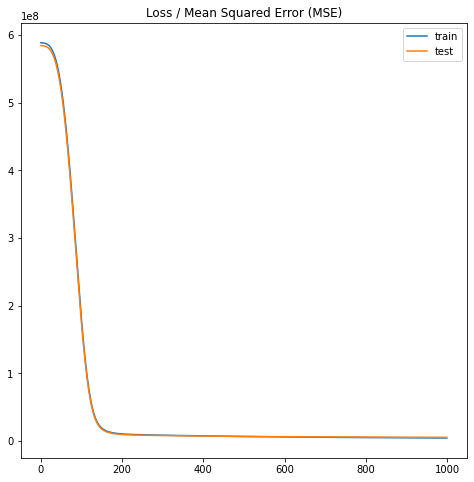

In [11]:
# evaluate the model
plt.figure(figsize=(8, 8))
metrics_train = model.evaluate(x_train, y_train, verbose=0)
metrics_test = model.evaluate(x_test, y_test, verbose=0)
print('Train RMSE:', metrics_train[1])
print('Train MAE:', metrics_train[2])
print('Test RMSE:', metrics_test[1])
print('Test MAE:', metrics_test[2])


# plot loss during training
plt.title('Loss / Mean Squared Error (MSE)')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.plot()
plt.legend()
plt.show()

In [13]:
#validation metrics
metrics_val = model.evaluate(x_val, y_val, verbose=0)
print('Validation RMSE:', metrics_val[1])
print('Validation MAE:', metrics_val[2])

Validation RMSE: 2685.953125
Validation MAE: 1879.3170166015625


In [14]:
#sets monetary values to plot axis 
def monetary_ticks(value, tick_number):
    return f'{value/1000:,.0f}'+'k'

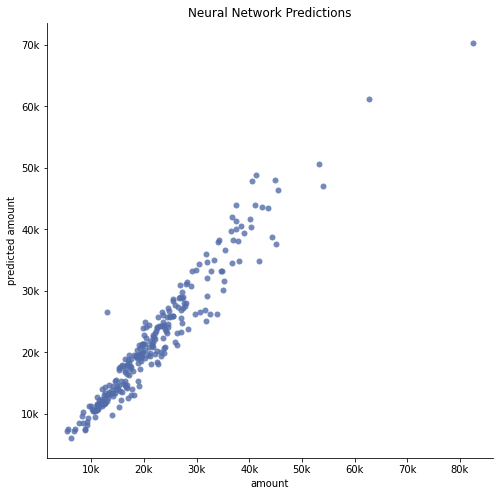

In [15]:
#predictions 
y_pred = model.predict(x_val).flatten()

plt.figure(figsize=(8, 8))
g = sns.scatterplot(x=y_val, y=y_pred, color = '#526ca9', alpha = 0.8, linewidth=0)
g.set_title('Neural Network Predictions')
g.set_xlabel('amount')
g.set_ylabel('predicted amount')

g.xaxis.set_major_formatter(FuncFormatter(monetary_ticks))
g.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))


sns.despine()
plt.show() 